# <center>Email Spam Classifer</center>
## <center>Clasify the Collection of SMS messages to tagged as spam or legitimate</center>

## Content
 * [***Introduction***](#introduction)
 * [***Data Visualization***](#visualization)
   * [***Distribution of text***](#distribution)
   * [***Wordcloud***](#wordcloud)
   * [***N-grams visualization***](#ngram)
 * [***Data pre-processing***](#preprocess)
 * [***Model Building***](#model)
   * [***Logistic Regression***](#logistic)
   * [***Naive Bayes***](#naive)
   * [***Support Vector Machine***](#support)
   * [***Random Forest Classifer***](#random)
 * [***Conclusion***](#conclusion)

<a id = 'introduction'></a>
## <Center>Introduction</center>
The SMS Spam Collection is a set of SMS tagged messages that have been collected for SMS Spam research. It contains one set of SMS messages in English of 5,574 messages, tagged acording being ham (legitimate) or spam. <br> The files contain one message per line. Each line is composed by two columns: **Label** contains the label (ham or spam) and **message** contains the raw text.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.linear_model import LogisticRegressionCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [2]:
data = pd.read_csv('datasets_483_982_spam.csv',encoding='latin-1')
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
data.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],inplace=True, axis=1)
data.columns = ['label','message']

In [4]:
data.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
data.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [6]:
data.groupby(['label']).describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

<a id ='visualization'></a>
# Data Visualization
Basic exploration of data to understand data.

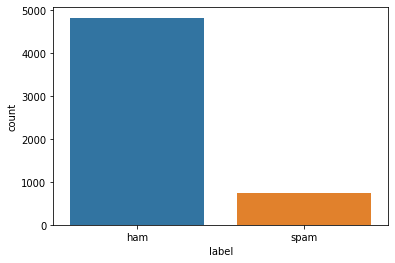

In [7]:
sns.countplot(data.label)

In [8]:
data.label.replace({'ham':0,'spam':1}, inplace=True)

<a id='distribution'></a>
## Distribution of Text
Length of data is analysis

Text(0.5, 0, 'Message Length')

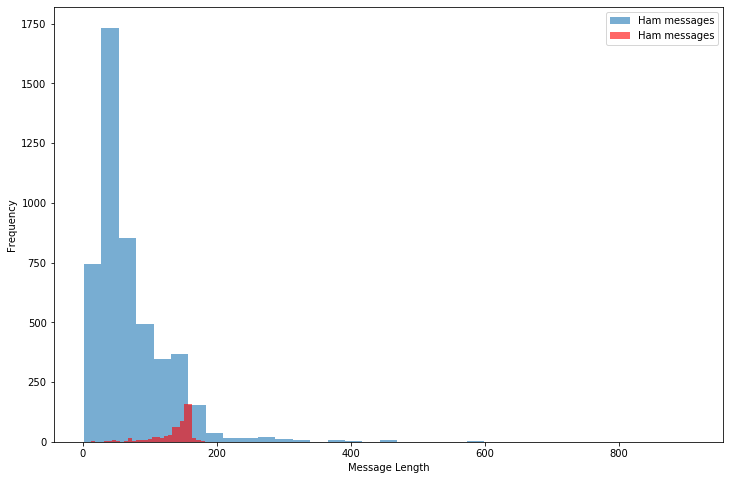

In [9]:
plt.figure(figsize=(12,8))
data[data.label==0].message.apply(len).plot(kind='hist',alpha=0.6,bins=35,label='Ham messages')
data[data.label==1].message.apply(len).plot(kind='hist', color='red',alpha=0.6,bins=35,label='Ham messages')

plt.legend()
plt.xlabel("Message Length")

<a id='wordcloud'></a>
## <center>WORDCLOUD</center>

## WORDCLOUD FOR TEXT THAT IS NOT SPAM

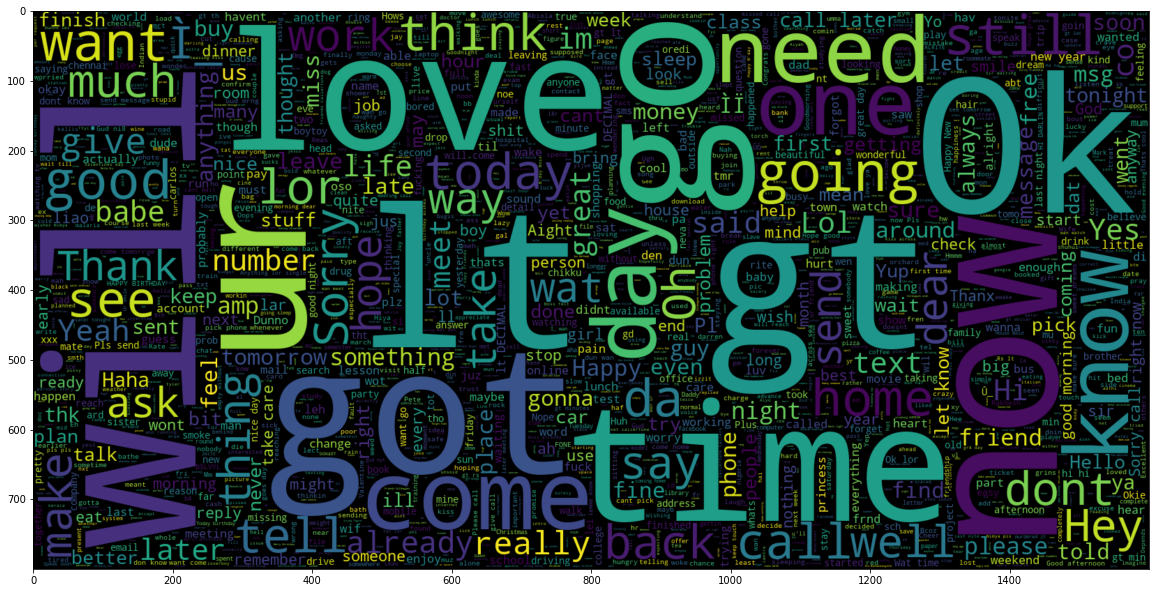

In [10]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(data[data.label == 0].message))
plt.imshow(wc , interpolation = 'bilinear')

## WORDCLOUD FOR TEXT THAT IS SPAM

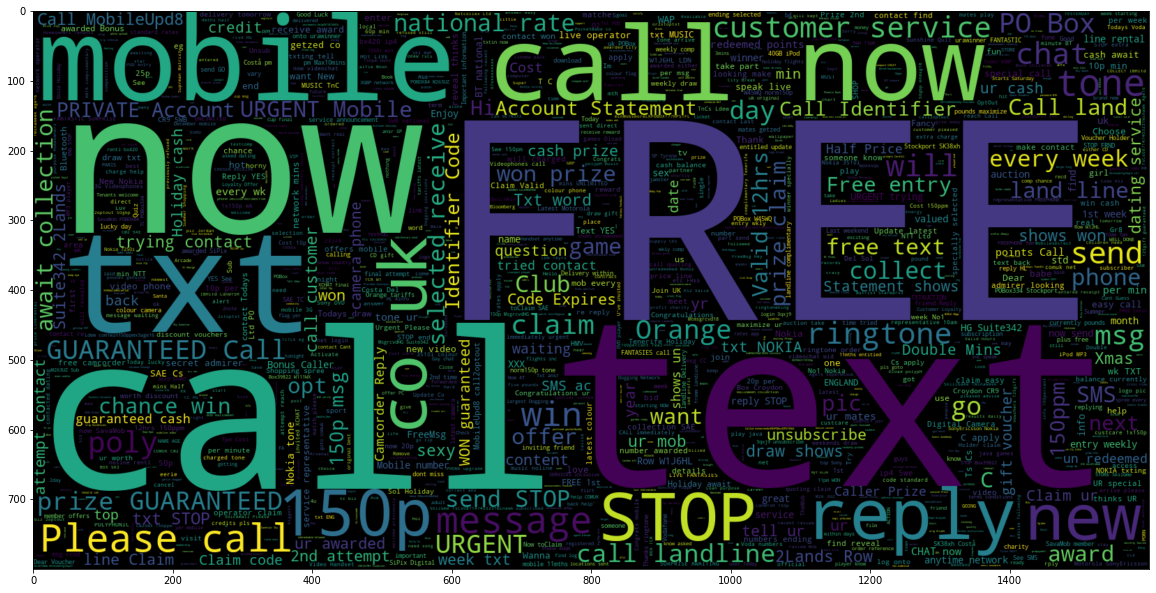

In [11]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(data[data.label == 1].message))
plt.imshow(wc , interpolation = 'bilinear')

<a id='ngram'></a>
## <center>N-gram visualization</center>

In [12]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(data.message)
corpus[:5]

['Go', 'until', 'jurong', 'point,', 'crazy..']

In [13]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'to': 2134,
 'you': 1622,
 'I': 1466,
 'a': 1327,
 'the': 1197,
 'and': 857,
 'in': 798,
 'is': 781,
 'i': 742,
 'u': 692}

## Uni-gram

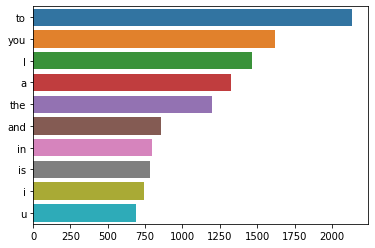

In [14]:
sns.barplot(x=list(most_common.values()),y=list(most_common.keys()))

## Bi-gram

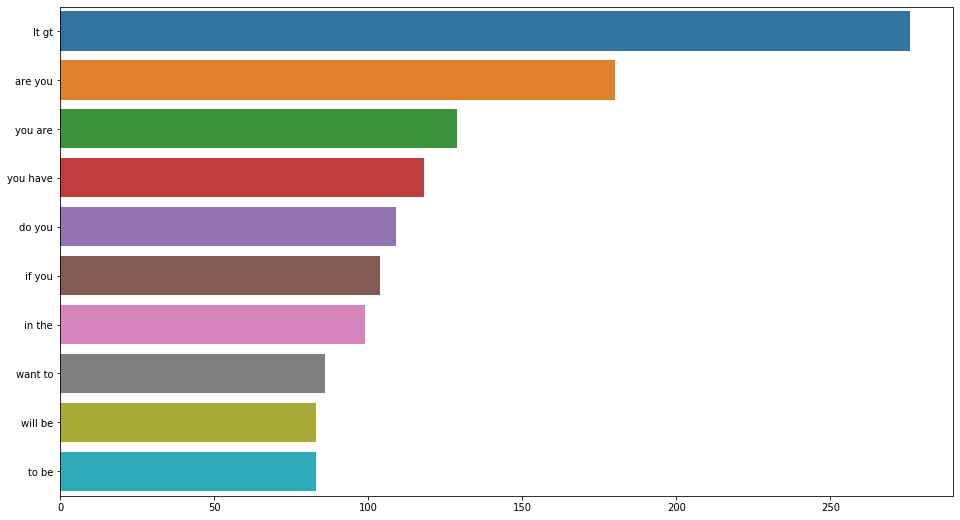

In [15]:
def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
plt.figure(figsize = (16,9))
most_common_bi = get_top_text_ngrams(data.message,10,2)
most_common_bi = dict(most_common_bi)
sns.barplot(x=list(most_common_bi.values()),y=list(most_common_bi.keys()))

## Tri-gram

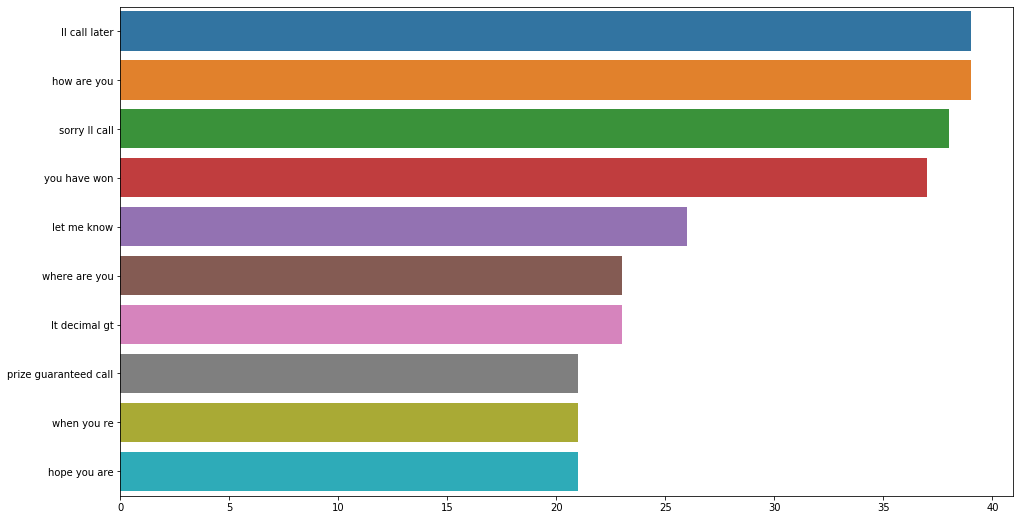

In [16]:
plt.figure(figsize = (16,9))
most_common_bi = get_top_text_ngrams(data.message,10,3)
most_common_bi = dict(most_common_bi)
sns.barplot(x=list(most_common_bi.values()),y=list(most_common_bi.keys()))

<a id = 'preprocess'></a>
# <center>Data Pre-Processing</center>

In [17]:
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    STOPWORDS = stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure']
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return ' '.join([word for word in nopunc.split() if word.lower() not in STOPWORDS])

In [18]:
textFeatures = data['message'].copy()
textFeatures = textFeatures.apply(text_process)
vectorizer = TfidfVectorizer("english")
features = vectorizer.fit_transform(textFeatures)

X_train, X_test, y_train, y_test = train_test_split(features, data['label'], test_size=0.3, random_state=111)


<5572x8672 sparse matrix of type '<class 'numpy.float64'>'
	with 73916 stored elements in Compressed Sparse Row format>

<a id = 'model'></a>
# <center>Model Building</center>

<a id= 'logistic'></a>
## Logistic Regression

In [186]:
clf = LogisticRegressionCV(cv=10, random_state=0)
clf.fit(X_train, y_train)
clf_prediction = clf.predict(X_test)
lg_acc = accuracy_score(y_test,clf_prediction)
print('\n')
print('Accuracy of Naive Bayes =',accuracy_score(y_test,clf_prediction))
print('\n-----------------\n')
print(classification_report(y_test,clf_prediction))



Accuracy of Naive Bayes = 0.9814593301435407

-----------------

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1440
           1       0.98      0.88      0.93       232

    accuracy                           0.98      1672
   macro avg       0.98      0.94      0.96      1672
weighted avg       0.98      0.98      0.98      1672



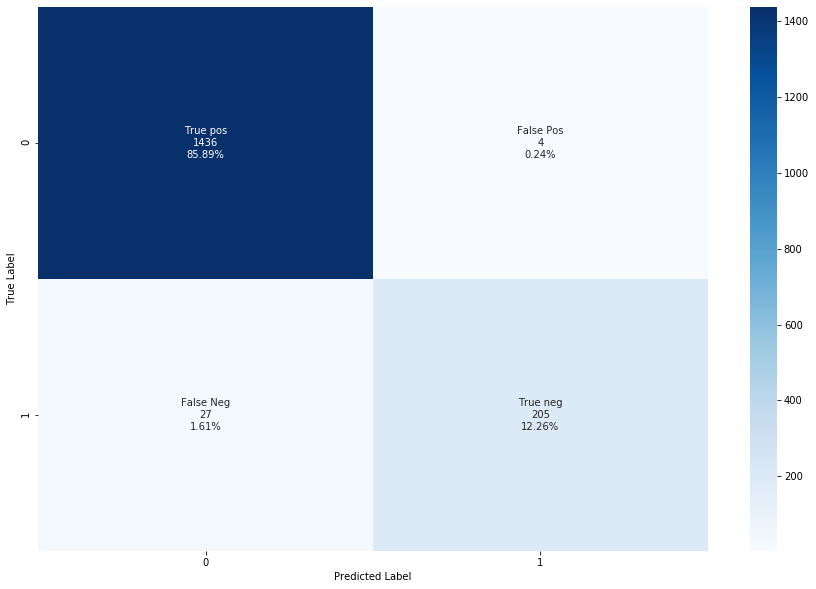

In [187]:
cf_matrix = confusion_matrix(y_true=y_test, y_pred=clf_prediction)
group_names = ['True pos','False Pos','False Neg','True neg']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize=(15,10))

sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label');

<a id='naive'></a>
## Naive Bayes

In [19]:
mnb = MultinomialNB(alpha=0.2)
mnb.fit(X_train, y_train)
mnb_prediction = mnb.predict(X_test)
mnb_acc=accuracy_score(y_test,mnb_prediction)
print('\n')
print('Accuracy of Naive Bayes =',accuracy_score(y_test,mnb_prediction))
print('\n-----------------\n')
print(classification_report(y_test,mnb_prediction))



Accuracy of Naive Bayes = 0.9826555023923444

-----------------

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1440
           1       0.94      0.94      0.94       232

    accuracy                           0.98      1672
   macro avg       0.96      0.96      0.96      1672
weighted avg       0.98      0.98      0.98      1672



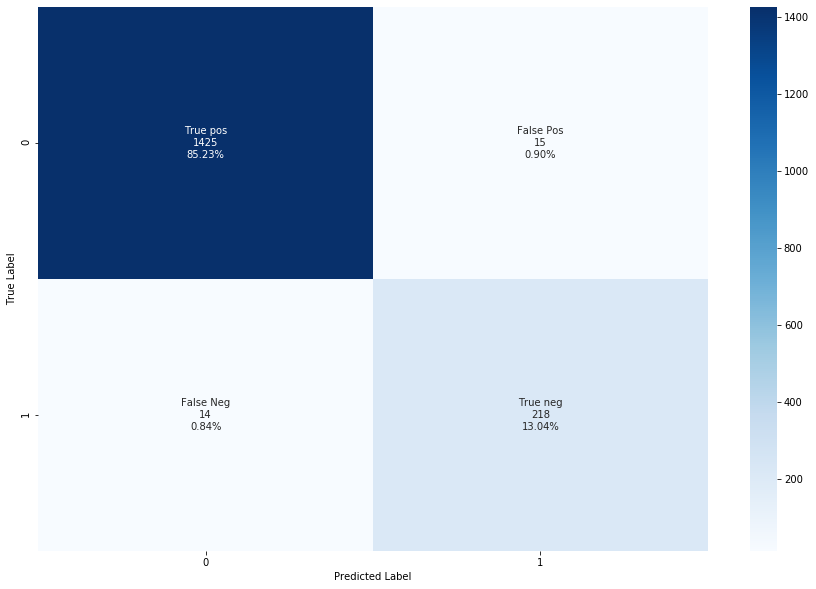

In [20]:
cf_matrix = confusion_matrix(y_true=y_test, y_pred=mnb_prediction)
group_names = ['True pos','False Pos','False Neg','True neg']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize=(15,10))

sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label');

<a id='Support'></a>
## Support Vector Machine

In [191]:
svm = SVC(kernel='sigmoid', gamma=1.0)
svm.fit(X_train, y_train)
svm_prediction = svm.predict(X_test)
svm_acc = accuracy_score(y_test,svm_prediction)
print('\n')
print('Accuracy of Naive Bayes =',accuracy_score(y_test,svm_prediction))
print('\n-----------------\n')
print(classification_report(y_test,svm_prediction))



Accuracy of Naive Bayes = 0.9760765550239234

-----------------

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1440
           1       0.98      0.84      0.91       232

    accuracy                           0.98      1672
   macro avg       0.98      0.92      0.95      1672
weighted avg       0.98      0.98      0.98      1672



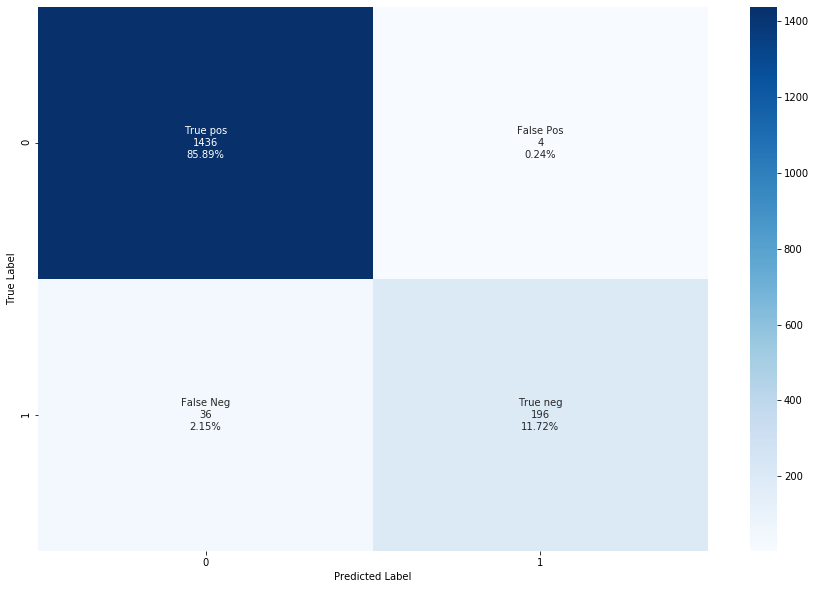

In [192]:
cf_matrix = confusion_matrix(y_true=y_test, y_pred=svm_prediction)
group_names = ['True pos','False Pos','False Neg','True neg']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize=(15,10))

sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label');

<a id='random'></a>
## Random Forest Classifier

In [193]:
rf = RandomForestClassifier(n_estimators=50, max_depth=None, n_jobs=-1)
rf.fit(X_train, y_train)
rf_prediction = rf.predict(X_test)
rf_acc = accuracy_score(y_test,rf_prediction)
print('\n')
print('Accuracy of Naive Bayes =',accuracy_score(y_test,rf_prediction))
print('\n-----------------\n')
print(classification_report(y_test,rf_prediction))



Accuracy of Naive Bayes = 0.9754784688995215

-----------------

              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1440
           1       1.00      0.82      0.90       232

    accuracy                           0.98      1672
   macro avg       0.99      0.91      0.94      1672
weighted avg       0.98      0.98      0.97      1672



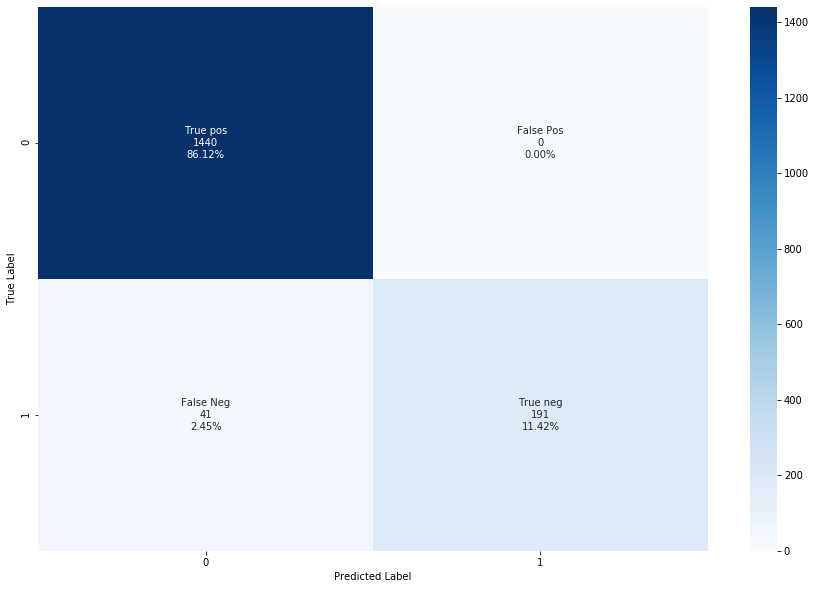

In [194]:
cf_matrix = confusion_matrix(y_true=y_test, y_pred=rf_prediction)
group_names = ['True pos','False Pos','False Neg','True neg']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize=(15,10))

sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label');

<a id='conclusion'></a>
# <center>Conclusion</center>

We have Tried ***Logistic Regression, Naive Bayes, Support Vector Machine and Random Forest classifier*** to compare which model perform best.

> Based on accuracy of models **Naive Bayes** outperform other classifier.

In [195]:
acc = np.argmax([lg_acc,mnb_acc,svm_acc,rf_acc])
classification = {0:'Logistic Regression',1:'Naive bayes',2:'Support Vector Classifcation',3:'Random Forest Classifier'}
print('Best classifier based on accuracy is {}'.format(classification[acc]))

Best classifier based on accuracy is Naive bayes


 >   But in our case we wish to more focus on reducing **False Positive**.
 >   - we want to select a model which doesn't classify Normal(Ham) messages as Spam messages because this could cause more   harm as important messages can be classified as spam and it can cause loss.
 >
 >   - so, In our case we should select model whose **precision** is better and also considering **Recall**.

>   To understand **Precision and Recall Trade Off**: 
>    - To fully evaluate the effectiveness of a model, we must examine both precision and recall.<br> </t>Unfortunately, precision and recall are often in tension. That is, improving precision typically reduces recall and vice versa.

### precision of Models

In [196]:
print('Logistic Regression  is ',precision_score(y_test, clf_prediction))
print('\n')
print('Naive Bayes is ',precision_score(y_test, mnb_prediction))
print('\n')
print('Support Vector Machine Regression is ',precision_score(y_test, svm_prediction))
print('\n')
print('Random Forest Classifer is ',precision_score(y_test, rf_prediction))

Logistic Regression  is  0.9808612440191388


Naive Bayes is  0.9356223175965666


Support Vector Machine Regression is  0.98


Random Forest Classifer is  1.0


### Recall of Models

In [197]:
print('Logistic Regression  is ',recall_score(y_test, clf_prediction))
print('\n')
print('Naive Bayes is ',recall_score(y_test, mnb_prediction))
print('\n')
print('Support Vector Machine Regression is ',recall_score(y_test, svm_prediction))
print('\n')
print('Random Forest Classifer is ',recall_score(y_test, rf_prediction))

Logistic Regression  is  0.8836206896551724


Naive Bayes is  0.9396551724137931


Support Vector Machine Regression is  0.8448275862068966


Random Forest Classifer is  0.8232758620689655


>  Considering overall performance of *** Precision and Recall***
> - Naive Bayes is Best Model.
>  Considering ***Precision***
> - Random Forest is Best Model.
> Considering ***Recall***
> - Naive Bayes is best model.



> ### Overall We should Select Either Naive Bayes model or Logistic Regession in Spam Classsifier Use Case.


In [21]:
from sklearn.externals import joblib
joblib.dump(mnb, 'NB_spam_model.pkl')

C:\Users\91800\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


['NB_spam_model.pkl']